In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class EmbeddingDotProduct(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim):
        super(EmbeddingDotProduct, self).__init__()
        self.user_embeddings = nn.Embedding(num_users, embedding_dim)
        self.item_embeddings = nn.Embedding(num_items, embedding_dim)

    def forward(self, user_indices, item_indices):
        user_embedding = self.user_embeddings(user_indices)
        item_embedding = self.item_embeddings(item_indices)

        if item_indices.dim() == 2:
            user_embedding = user_embedding.unsqueeze(1)

        return (user_embedding * item_embedding).sum(1)

In [4]:
def bpr_loss(positive_scores, negative_scores):
    return -torch.mean(torch.log(torch.sigmoid(positive_scores.unsqueeze(1) - negative_scores)))

In [5]:
scores = np.load("./drive/MyDrive/ВШМ/DL/scores_numpy.npy")
interactions = np.load("./drive/MyDrive/ВШМ/DL/interactions_numpy.npy")

In [6]:
interactions_positive = interactions[scores > 80, :]
np.random.shuffle(interactions_positive)

In [7]:
num_users = int(interactions[:, 0].max()) + 1
num_items = int(interactions[:, 1].max()) + 1
embedding_dim = 128

In [8]:
def generate_negative_samples(num_items, positive_items, num_neg_samples): 
    #there can be intersections with positives but odds are low.
    negative_samples = np.random.choice(num_items, (positive_items.shape[0], num_neg_samples), replace=False)
    return negative_samples

In [9]:
model = EmbeddingDotProduct(num_users, num_items, embedding_dim)

In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EmbeddingDotProduct(
  (user_embeddings): Embedding(249012, 128)
  (item_embeddings): Embedding(296111, 128)
)

In [11]:
num_epochs = 5
batch_size = 3000
num_negative_samples = 5

for epoch in range(num_epochs):
    batch_loss = []
    epoch_losses = []

    for ix, batch_start in enumerate(range(0, len(interactions_positive), batch_size)):
        if ix % 5000 == 4999:
          print(f"{ix} batches out of ", len(interactions_positive) // batch_size)
          print(f"loss: {np.mean(batch_loss)}")
          batch_loss = []

        batch_data = interactions_positive[batch_start:batch_start + batch_size]
        batch_positive_users = torch.LongTensor(batch_data[:, 0]).to(device)
        batch_positive_items = torch.LongTensor(batch_data[:, 1]).to(device)
        
        # Sample negative items
        batch_negative_items_np = generate_negative_samples(num_items, batch_data[:, 1], num_negative_samples)
        batch_negative_items = torch.LongTensor(batch_negative_items_np).to(device)
        
        # Calculate scores
        positive_scores = model(batch_positive_users, batch_positive_items)
        negative_scores = model(batch_positive_users, batch_negative_items)
        
        # Compute loss
        loss = bpr_loss(positive_scores, negative_scores)
        batch_loss.append(loss.detach().cpu())
        epoch_losses.append(loss.detach().cpu())
        # Backpropagate and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {np.mean(epoch_losses)}")
    epoch_losses = []

4999 batches out of  6857
loss: 4.389402866363525
Epoch 1/5 - Loss: 4.2938947677612305
4999 batches out of  6857
loss: 3.3747928142547607
Epoch 2/5 - Loss: 3.295471429824829
4999 batches out of  6857
loss: 2.5659914016723633
Epoch 3/5 - Loss: 2.502016067504883
4999 batches out of  6857
loss: 1.8957449197769165
Epoch 4/5 - Loss: 1.8333356380462646
4999 batches out of  6857
loss: 1.2882195711135864
Epoch 5/5 - Loss: 1.2303619384765625


<Axes: >

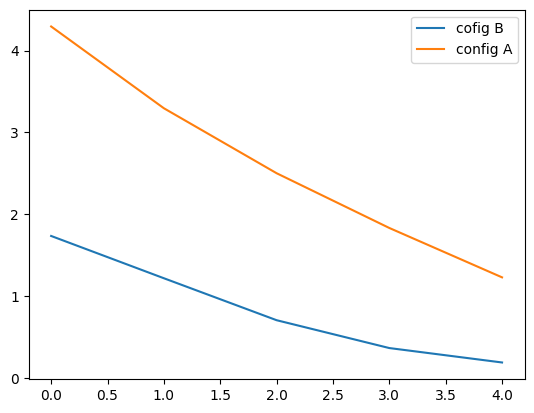

In [14]:
# a bit cringe but i forgot to log losses (again)
loss_per_epoch_config_1 = [1.7357902526855469, 1.2195569276809692, 0.7071095108985901, 0.36702361702919006, 0.1909148246049881]
loss_per_epoch_config_2 = [4.2938947677612305, 3.295471429824829, 2.502016067504883, 1.8333356380462646, 1.2303619384765625]

pd.DataFrame({'cofig B': loss_per_epoch_config_1, 'config A': loss_per_epoch_config_2}).plot()